## 텐서플로 분류 모델 만들기
* [첫 번째 신경망 훈련하기: 기초적인 분류 문제  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/classification)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

import tensorflow as tf
from tqdm import tqdm
import tensorflow_addons as tfa

In [2]:
# 데이터셋을 불러옵니다.
df = pd.read_csv("http://bit.ly/data-diabetes-csv")
df.shape

(768, 9)

In [3]:
# 미리보기를 합니다.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 전체 수치변수 시각화 

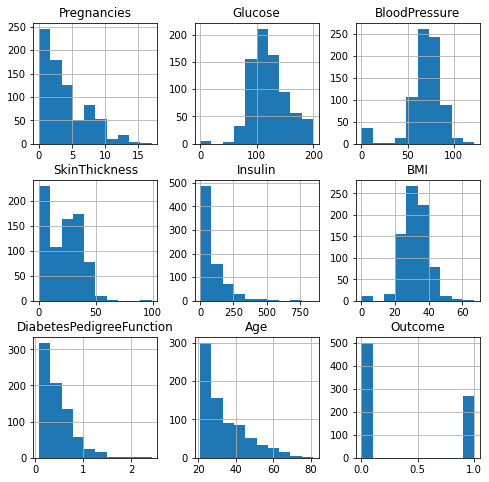

In [4]:
# 히스토그램으로 시각화 합니다.
_ = df.hist(figsize=(8,8))

In [5]:
# describe 로 요약합니다.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 데이터 전처리
### 인슐린의 0을 다른 값으로 대체하기

In [6]:
# Insulin 이 0 인 값을 다른 값으로 대체하기
# df["Insulin_nan"]
df["Insulin_nan"] = df['Insulin'].replace(0,np.nan)
df.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_nan
0,6,148,72,35,0,33.6,0.627,50,1,NaN


In [7]:
# 당뇨병 여부에 따라 groupby로 인슐린의 중앙값 구하기
imputation = df.groupby('Outcome')['Insulin'].median()
imputation

Outcome
0    39.0
1     0.0
Name: Insulin, dtype: float64

In [8]:
# 변수에 할당한 값 확인하기
print('Outcome 0 : Imputation',imputation[0])
print('Outcome 1 : Imputation',imputation[1])

imp0 = df.loc[(df['Insulin_nan'].isna()) & (df['Outcome'] == 0)]
imp1 = df.loc[(df['Insulin_nan'].isna()) & (df['Outcome'] == 1)]
print('imp0.shape :',imp0.shape)
print('imp1.shape :',imp1.shape)

Outcome 0 : Imputation 39.0
Outcome 1 : Imputation 0.0
imp0.shape : (236, 10)
imp1.shape : (138, 10)


In [9]:
# 당뇨병 여부에 따라 인슐린값 대체하기
df.loc[imp0.index,'Insulin_nan'] = imputation[0]
df.loc[imp1.index,'Insulin_nan'] = imputation[1]
df.drop('Insulin',axis=1,inplace=True)

In [10]:
df.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_nan
0,6,148,72,35,33.6,0.627,50,1,0.0


## 데이터셋 나누기

In [11]:
# label_name
label_name = 'Outcome'

In [12]:
# X, y 만들기
X = df.drop('Outcome',axis=1)
y = df['Outcome']
print('X.shape :',X.shape)
print('y.shape :',y.shape)

X.shape : (768, 8)
y.shape : (768,)


In [13]:
# sklearn.model_selection 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, stratify=y)

print('X_train.shape :',X_train.shape)
print('X_test.shape :',X_test.shape)
print('y_train.shape :',y_train.shape)
print('y_test.shape :',y_test.shape)

X_train.shape : (614, 8)
X_test.shape : (154, 8)
y_train.shape : (614,)
y_test.shape : (154,)


In [14]:
# 입력데이터 수 구하기
# input_shape
input_shape = 9

<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

* [첫 번째 신경망 훈련하기: 기초적인 분류 문제  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/classification)

* 층 설정
    * 신경망의 기본 구성 요소는 층(layer)입니다. 
    * 층은 주입된 데이터에서 표현을 추출합니다. 
    * 대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. 
    * tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

* Dense Layer: 
    * 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 
    * 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 
    * 마지막 층은 출력층 입니다.
        * 소프트맥스 일 때 : 2개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 2개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 
        * 각 노드는 현재 이미지가 2개 클래스 중 하나에 속할 확률을 출력합니다.
        * 시그모이드 일 때 : 둘 중 하나를 예측할 때 1개의 출력값을 출력합니다. 확률을 받아 임계값 기준으로 True, False로 나눕니다.
    
    
* 출력층 :
    * 예측 값이 n개 일 때 :  tf.keras.layers.Dense(n, activation='softmax')
    * 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid')
    
    
* 드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

* tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다. (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

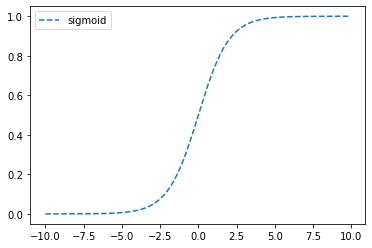

In [15]:
# x축은 원래 값을 y축은 sigmoid 함수를 통과시킨 값입니다. 
x = np.arange(-10, 10, 0.1)
plt.plot(x, tf.keras.activations.sigmoid(x), linestyle='--', label="sigmoid") 
plt.legend()
plt.show()

In [16]:
# tensorflow 를 tf로 불러오기
import tensorflow as tf

In [162]:
init = tf.keras.initializers.GlorotNormal()
reg = tf.keras.regularizers.L2(l2=0.01)

# 입력-히든-출력(sigmoid) 레이어로 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[X_train.shape[1]], activation='relu', kernel_initializer=init),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

* 옵티마이저(Optimizer) - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표(Metrics) - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


* 손실 함수(Loss function) - 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다. 최적의 가중치를 찾도록 해야함
    * 회귀  : MSE, MAE
    * 분류 : 
        * 바이너리(예측할 값의 종류가 둘 중 하나) : 
            * binary_crossentropy
        * 멀티클래스(예측할 값의 종류가 2개 이상) : 
            * categorical crossentropy(one-hot형태의 클래스 예: [0, 1, 0, 0])
            * sparse categorical crossentropy(정답값이 0, 1, 2, 3, 4 와 같은 형태일 때)

In [163]:
# 모델 컴파일
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer_use = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model.compile(loss='BinaryCrossentropy', optimizer=optimizer_use, metrics=['accuracy'])

In [164]:
# 모델 요약
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 64)                576       
                                                                 
 dense_132 (Dense)           (None, 128)               8320      
                                                                 
 batch_normalization_49 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_133 (Dense)           (None, 256)               33024     
                                                                 
 dense_134 (Dense)           (None, 512)               131584    
                                                     

In [165]:
# CallBack Functions
checkpoint_dir = 'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'
patience_time = 30

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience_time)
cp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, verbose=1,
                                       save_weights_only = True,
                                       save_best_only = True)

## 학습
* 배치(batch): 모델 학습에 한 번에 입력할 데이터셋
* 에폭(epoch): 모델 학습시 전체 데이터를 학습한 횟 수
* 스텝(step): (모델 학습의 경우) 하나의 배치를 학습한 횟 수

In [166]:
# 학습하기
# history

tqdm_callback = tfa.callbacks.TQDMProgressBar()

start = time.time()
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                   batch_size=32, verbose=0,
                   callbacks=[early_stopping, cp, tqdm_callback])
end = time.time()
history

Training:   0%|                                                                               0/200 ETA: ?s,  …

Epoch 1/200


0/16                                                                                                         E…


Epoch 1: val_loss improved from inf to 40.77650, saving model to Training_checkpoint\cp-0001-40.78.ckpt
Epoch 2/200


0/16                                                                                                         E…


Epoch 2: val_loss improved from 40.77650 to 3.83776, saving model to Training_checkpoint\cp-0002-3.84.ckpt
Epoch 3/200


0/16                                                                                                         E…


Epoch 3: val_loss improved from 3.83776 to 1.21668, saving model to Training_checkpoint\cp-0003-1.22.ckpt
Epoch 4/200


0/16                                                                                                         E…


Epoch 4: val_loss did not improve from 1.21668
Epoch 5/200


0/16                                                                                                         E…


Epoch 5: val_loss did not improve from 1.21668
Epoch 6/200


0/16                                                                                                         E…


Epoch 6: val_loss did not improve from 1.21668
Epoch 7/200


0/16                                                                                                         E…


Epoch 7: val_loss improved from 1.21668 to 0.99442, saving model to Training_checkpoint\cp-0007-0.99.ckpt
Epoch 8/200


0/16                                                                                                         E…


Epoch 8: val_loss improved from 0.99442 to 0.95021, saving model to Training_checkpoint\cp-0008-0.95.ckpt
Epoch 9/200


0/16                                                                                                         E…


Epoch 9: val_loss did not improve from 0.95021
Epoch 10/200


0/16                                                                                                         E…


Epoch 10: val_loss did not improve from 0.95021
Epoch 11/200


0/16                                                                                                         E…


Epoch 11: val_loss did not improve from 0.95021
Epoch 12/200


0/16                                                                                                         E…


Epoch 12: val_loss improved from 0.95021 to 0.51411, saving model to Training_checkpoint\cp-0012-0.51.ckpt
Epoch 13/200


0/16                                                                                                         E…


Epoch 13: val_loss did not improve from 0.51411
Epoch 14/200


0/16                                                                                                         E…


Epoch 14: val_loss improved from 0.51411 to 0.43837, saving model to Training_checkpoint\cp-0014-0.44.ckpt
Epoch 15/200


0/16                                                                                                         E…


Epoch 15: val_loss did not improve from 0.43837
Epoch 16/200


0/16                                                                                                         E…


Epoch 16: val_loss did not improve from 0.43837
Epoch 17/200


0/16                                                                                                         E…


Epoch 17: val_loss did not improve from 0.43837
Epoch 18/200


0/16                                                                                                         E…


Epoch 18: val_loss did not improve from 0.43837
Epoch 19/200


0/16                                                                                                         E…


Epoch 19: val_loss did not improve from 0.43837
Epoch 20/200


0/16                                                                                                         E…


Epoch 20: val_loss did not improve from 0.43837
Epoch 21/200


0/16                                                                                                         E…


Epoch 21: val_loss did not improve from 0.43837
Epoch 22/200


0/16                                                                                                         E…


Epoch 22: val_loss improved from 0.43837 to 0.37535, saving model to Training_checkpoint\cp-0022-0.38.ckpt
Epoch 23/200


0/16                                                                                                         E…


Epoch 23: val_loss did not improve from 0.37535
Epoch 24/200


0/16                                                                                                         E…


Epoch 24: val_loss did not improve from 0.37535
Epoch 25/200


0/16                                                                                                         E…


Epoch 25: val_loss did not improve from 0.37535
Epoch 26/200


0/16                                                                                                         E…


Epoch 26: val_loss did not improve from 0.37535
Epoch 27/200


0/16                                                                                                         E…


Epoch 27: val_loss did not improve from 0.37535
Epoch 28/200


0/16                                                                                                         E…


Epoch 28: val_loss did not improve from 0.37535
Epoch 29/200


0/16                                                                                                         E…


Epoch 29: val_loss did not improve from 0.37535
Epoch 30/200


0/16                                                                                                         E…


Epoch 30: val_loss did not improve from 0.37535
Epoch 31/200


0/16                                                                                                         E…


Epoch 31: val_loss did not improve from 0.37535
Epoch 32/200


0/16                                                                                                         E…


Epoch 32: val_loss did not improve from 0.37535
Epoch 33/200


0/16                                                                                                         E…


Epoch 33: val_loss did not improve from 0.37535
Epoch 34/200


0/16                                                                                                         E…


Epoch 34: val_loss did not improve from 0.37535
Epoch 35/200


0/16                                                                                                         E…


Epoch 35: val_loss did not improve from 0.37535
Epoch 36/200


0/16                                                                                                         E…


Epoch 36: val_loss did not improve from 0.37535
Epoch 37/200


0/16                                                                                                         E…


Epoch 37: val_loss did not improve from 0.37535
Epoch 38/200


0/16                                                                                                         E…


Epoch 38: val_loss did not improve from 0.37535
Epoch 39/200


0/16                                                                                                         E…


Epoch 39: val_loss did not improve from 0.37535
Epoch 40/200


0/16                                                                                                         E…


Epoch 40: val_loss did not improve from 0.37535
Epoch 41/200


0/16                                                                                                         E…


Epoch 41: val_loss did not improve from 0.37535
Epoch 42/200


0/16                                                                                                         E…


Epoch 42: val_loss did not improve from 0.37535
Epoch 43/200


0/16                                                                                                         E…


Epoch 43: val_loss did not improve from 0.37535
Epoch 44/200


0/16                                                                                                         E…


Epoch 44: val_loss did not improve from 0.37535
Epoch 45/200


0/16                                                                                                         E…


Epoch 45: val_loss did not improve from 0.37535
Epoch 46/200


0/16                                                                                                         E…


Epoch 46: val_loss did not improve from 0.37535
Epoch 47/200


0/16                                                                                                         E…


Epoch 47: val_loss did not improve from 0.37535
Epoch 48/200


0/16                                                                                                         E…


Epoch 48: val_loss did not improve from 0.37535
Epoch 49/200


0/16                                                                                                         E…


Epoch 49: val_loss did not improve from 0.37535
Epoch 50/200


0/16                                                                                                         E…


Epoch 50: val_loss did not improve from 0.37535
Epoch 51/200


0/16                                                                                                         E…


Epoch 51: val_loss did not improve from 0.37535
Epoch 52/200


0/16                                                                                                         E…


Epoch 52: val_loss did not improve from 0.37535


In [167]:
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:15


In [168]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
# df_hist
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,3.386697,0.767821,40.776501,0.300813
1,1.630572,0.820774,3.837765,0.300813
2,0.766911,0.847251,1.216677,0.308943
3,0.641991,0.841141,2.540817,0.317073
4,0.660572,0.845214,1.317711,0.325203


In [169]:
df_hist.sort_values(by='val_loss').head(1)

,loss,accuracy,val_loss,val_accuracy
21,0.454531,0.869654,0.375346,0.894309


### 학습결과 시각화 

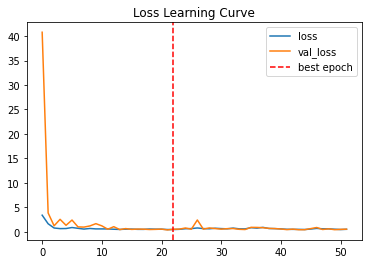

In [170]:
# loss, accuracy 값 시각화 
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss')
plt.plot(df_hist.val_loss, label='val_loss')
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.legend()
plt.show()

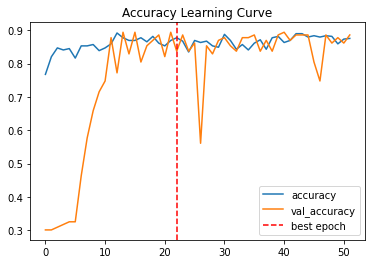

In [171]:
plt.title('Accuracy Learning Curve')
plt.plot(df_hist.accuracy, label='accuracy')
plt.plot(df_hist.val_accuracy, label='val_accuracy')
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.legend()
plt.show()

## 예측

In [172]:
# 예측값을 y_pred 변수에 할당 후 재사용합니다.
# y_pred
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


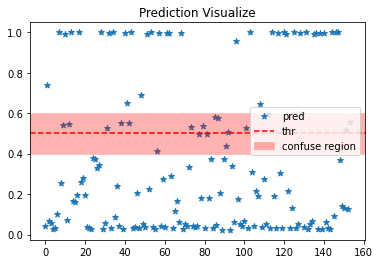

In [173]:
# 예측값 시각화
# 임계값을 정해서 특정값 이상이면 True, 아니면 False로 변환해서 사용할 예정입니다.
thr = 0.5
plt.title('Prediction Visualize')
plt.scatter(np.arange(X_test.shape[0]),y_pred, marker='*', label='pred')
plt.axhline(0.5,color='red',linestyle='--', label='thr')
plt.axhspan(ymin=0.4, ymax=0.6, linestyle=':', label='confuse region', color='r', alpha=0.3)
plt.legend(loc='best')
plt.show()

## 평가

In [174]:
# test_loss, test_acc
# print('\n테스트 정확도:', test_acc)

test_loss, test_acc = model.evaluate(X_test,y_test)
print('test loss :',np.round(test_loss,4))
print('test acc :',np.round(test_acc,4))

5/5 [==============================] - 0s 4ms/step - loss: 0.5194 - accuracy: 0.8831
test loss : 0.5194
test acc : 0.8831


In [175]:
# argmax는 다차원 배열의 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수
# 출력층에서 softmax 사용 시 확률로 반환되기 때문에 그 중 가장 높은 값의 인덱스를 찾을 때 사용
# y_predict = np.argmax(y_pred, axis=1)
# 출력층 sigmoid 사용 시 flatten 을 통해 예측값을 1차원으로 변환
# 0.5 이상의 값을 True 로 하고 int32 타입으로 변경
# y_predict

y_predict = (y_pred > 0.5).astype(int)
print('y_predict :',y_predict.shape)
print('y_test :',y_test.shape)

y_predict : (154, 1)
y_test : (154,)


In [176]:
# 직접 정확도 측정하기
from sklearn.metrics import confusion_matrix, accuracy_score
print('accuracy_score :',np.round(accuracy_score(y_test,y_predict),4))

accuracy_score : 0.8831


In [161]:
# # 모델 저장
# model.save('save/Model/')